In [1]:
!pip install datasets
!pip install -q bitsandbytes accelerate loralib datasets
!pip install -q git+https://github.com/huggingface/transformers.git@main git+https://github.com/huggingface/peft.git

In [2]:
from training_utils import (
    run_job
)

STARTED
teacher prompt
Think logically. Are the following sentences duplicates or paraphrases of each other, yes or no?
student prompt
Are the following sentences duplicates or paraphrases of each other, yes or no?
starting run: 0
loading model
ids loaded for model:
1940566727024 1940524298992 1940566340576
finished loading model
loading data
metrics of data load
32 32 2 32
examples:
Think logically. Are the following sentences duplicates or paraphrases of each other, yes or no?

Question1: What do prisoners in Saudi Arabia get to eat?
Question2: What is prison like in Saudi Arabia?
Label: yes

Question1: What should I do to reduce weight?
Question2: How can I lose an extreme amount of weight?
Label: no

Question1: How can I check the CPU performance (MIPS) of my computer? Is there any command windows?
Question2: What is the best way to check your CPU usage in Solaris?
Label:
Are the following sentences duplicates or paraphrases of each other, yes or no?

Question1: How can I check the

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


current_index
1
current_index
2
current_index
3
current_index
4
current_index
5
current_index
6
current_index
7
current_index
8
current_index
9
current_index
10
current_index
11
current_index
12
current_index
13
current_index
14
current_index
15
current_index
16
current_index
17
current_index
18
current_index
19
current_index
20
current_index
21
current_index
22
current_index
23
current_index
24
current_index
25
current_index
26
current_index
27
current_index
28
current_index
29
current_index
30
current_index
31
Epoch 1, Total Loss: 4.762568220496178
Total loss : 4.762568220496178


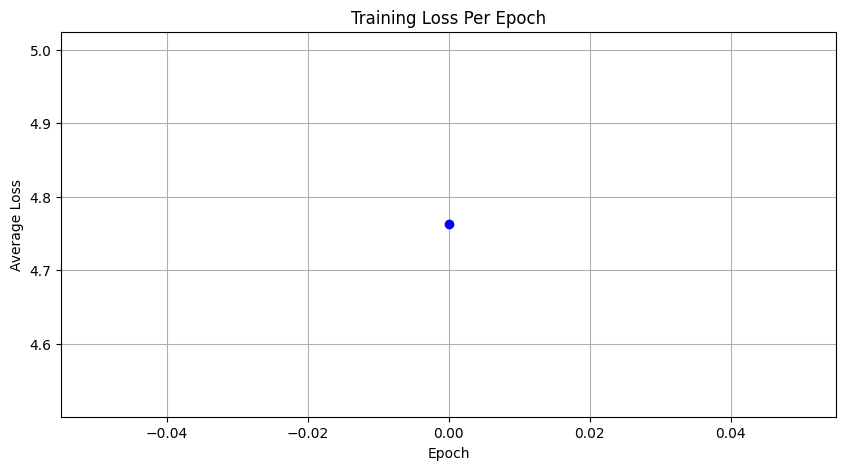

finished training model
predicting teacher on validation set
model used
1940566340576
decoded output
Think logically. Are the following sentences duplicates or paraphrases of each other, yes or no?

Question1: What do prisoners in Saudi Arabia get to eat?
Question2: What is prison like in Saudi Arabia?
Label: yes

Question1: What should I do to reduce weight?
Question2: How can I lose an extreme amount of weight?
Label: no

Question1: What should I do to crack Gsoc '16?
Question2: How should I prepare for GSoc 2017?
Label: yes
finished run in-domain teacher val0
final result 0.65625
predicting in-domain on validation set
indomain sample
Are the following sentences duplicates or paraphrases of each other, yes or no?

Question1: Is losing weight possible without hitting the gym like a maniac?
Question2: How can I lose weight without going to the gym?
Label:
model used
1940524298992


C:\Users\Chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


decoded output
Are the following sentences duplicates or paraphrases of each other, yes or no?

Question1: How much space does Mac OS X Yosemite take on a new MacBook?
Question2: Can I install Mac OS X on my HP laptop?
Label:

finished run in-domain val0
final result 0.0
predicting on paws_qqp
paws_qqp_dataset
Dataset({
    features: ['idx', 'sentence1', 'sentence2', 'label'],
    num_rows: 677
})
paws-qqp sample
Are the following sentences duplicates or paraphrases of each other, yes or no?

Question1: What were the major effects of the cambodia earthquake , and how do these effects compare to the Iquique earthquake in 1877 ?
Question2: What were the major effects of the Iquique earthquake , and how do these effects compare to the cambodia earthquake in 1877 ?
Label:
model used
1940524298992


C:\Users\Chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


decoded output
Are the following sentences duplicates or paraphrases of each other, yes or no?

Question1: Which is more common, a liberal Democrat or a conservative Republican? Why so?
Question2: Which is more common, a conservative Democrat or a liberal Republican? Why so?
Label:

finished run ood 0
final result 0.0
compare indexes
[  927 38485 10430 20304  6059 18075 32251 29387 15952  2476 24778 34903
 27011 39208  3744 21731 15253   996  1333  1882 32665 27447 22529 38483
 25251 32321 29594 15270 17318 15137 31320  9962 38604 17133 11935  7719
 29099 36046 22078 26590 31241 24745 23846 16525 30322  5936  6867   902
 39515 24645 31265 16714 26696  2922 32674 20387 33601 30917 31824 12498
 30144 20199 28571 33583 16198  9985 39937 24815 15655   262 37639 19958
 30412  9902 34962  2069 25397 11624  7560 35265 38281 30256 31665  9620
 15479  1678  8376 27846 21440 28254  8473 20659 22786 27753 20166 38395
  1147 40123 25496  7961]
[  1   2   3   4   5   6   7   8   9  10  11  12  13  

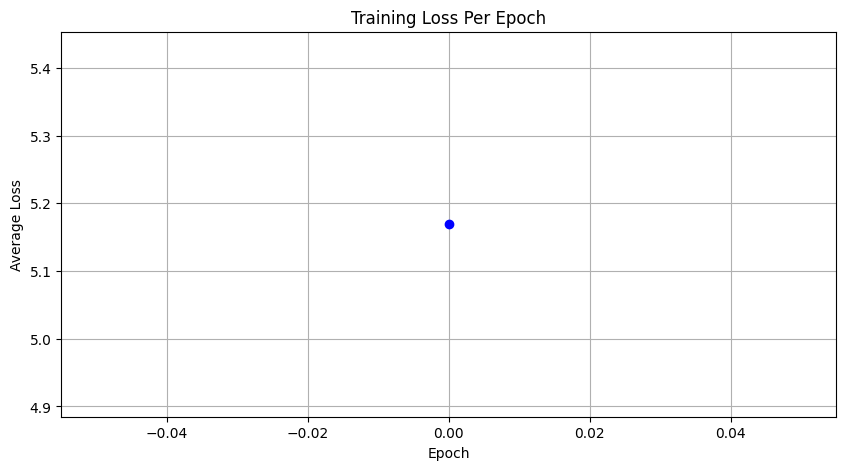

finished training model
predicting teacher on validation set
model used
1940556762432
decoded output
Think logically. Are the following sentences duplicates or paraphrases of each other, yes or no?

Question1: What are the books suggested for the CSAT?
Question2: What are the best books for the CSAT?
Label: no

Question1: "How do I fix the problem ""plugged in not charging"" on my Dell Inspiron laptop?"
Question2: How to fix a laptop that is plugged in but is not charging with Windows 7?
Label: yes

Question1: What are the different ways of submitting a Request for a Disability Hearing?
Question2: How good is the scope for a freelance industrial engineer in India and abroad?
Label: yes
finished run in-domain teacher val1
final result 0.71875
predicting in-domain on validation set
indomain sample
Are the following sentences duplicates or paraphrases of each other, yes or no?

Question1: Is losing weight possible without hitting the gym like a maniac?
Question2: How can I lose weight wit

C:\Users\Chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


decoded output
Are the following sentences duplicates or paraphrases of each other, yes or no?

Question1: How much space does Mac OS X Yosemite take on a new MacBook?
Question2: Can I install Mac OS X on my HP laptop?
Label: Yes
finished run in-domain val1
final result 0.0
predicting on paws_qqp
paws_qqp_dataset
Dataset({
    features: ['idx', 'sentence1', 'sentence2', 'label'],
    num_rows: 677
})
paws-qqp sample
Are the following sentences duplicates or paraphrases of each other, yes or no?

Question1: What were the major effects of the cambodia earthquake , and how do these effects compare to the Iquique earthquake in 1877 ?
Question2: What were the major effects of the Iquique earthquake , and how do these effects compare to the cambodia earthquake in 1877 ?
Label:
model used
1940566732112


C:\Users\Chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\checkpoint.py:90: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


decoded output
Are the following sentences duplicates or paraphrases of each other, yes or no?

Question1: Which is more common, a liberal Democrat or a conservative Republican? Why so?
Question2: Which is more common, a conservative Democrat or a liberal Republican? Why so?
Label:

finished run ood 1
final result 0.0
compare indexes
[  927 38485 10430 20304  6059 18075 32251 29387 15952  2476 24778 34903
 27011 39208  3744 21731 15253   996  1333  1882 32665 27447 22529 38483
 25251 32321 29594 15270 17318 15137 31320  9962 38604 17133 11935  7719
 29099 36046 22078 26590 31241 24745 23846 16525 30322  5936  6867   902
 39515 24645 31265 16714 26696  2922 32674 20387 33601 30917 31824 12498
 30144 20199 28571 33583 16198  9985 39937 24815 15655   262 37639 19958
 30412  9902 34962  2069 25397 11624  7560 35265 38281 30256 31665  9620
 15479  1678  8376 27846 21440 28254  8473 20659 22786 27753 20166 38395
  1147 40123 25496  7961]
[  1   2   3   4   5   6   7   8   9  10  11  12  13  

In [3]:
# Models "opt-125m", "opt-350m", "opt-1.3b", "opt-2.6b"
# Datasets "mnli", "rte", "qqp"
runs = 2#4
dataset_used = 'qqp'
indomain = False
model_name = "opt-125m"
epochs = 1#20
val_len = 100
train_len = 32

for seed in range(runs):
    for context_len in [2]:#,16,32]:
        print("STARTED")
        run_job(dataset_used, model_name, epochs, val_len, train_len, context_len, seed)
        print("FINISHED")